In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

CHANNELS=3  
EPOCHS=60


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato",
    shuffle=True,
    
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 2816 files belonging to 10 classes.


potato_early_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato_Early_blight"

potato_lately_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___Late_blight"

potato_healthy = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___healthy"

In [6]:
class_names = dataset.class_names

class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())  #batch size 32 256 image size 

(32, 256, 256, 3)
[1 2 2 0 1 9 1 7 2 4 5 0 2 3 9 0 4 3 0 2 1 6 3 9 9 8 1 4 5 3 1 9]


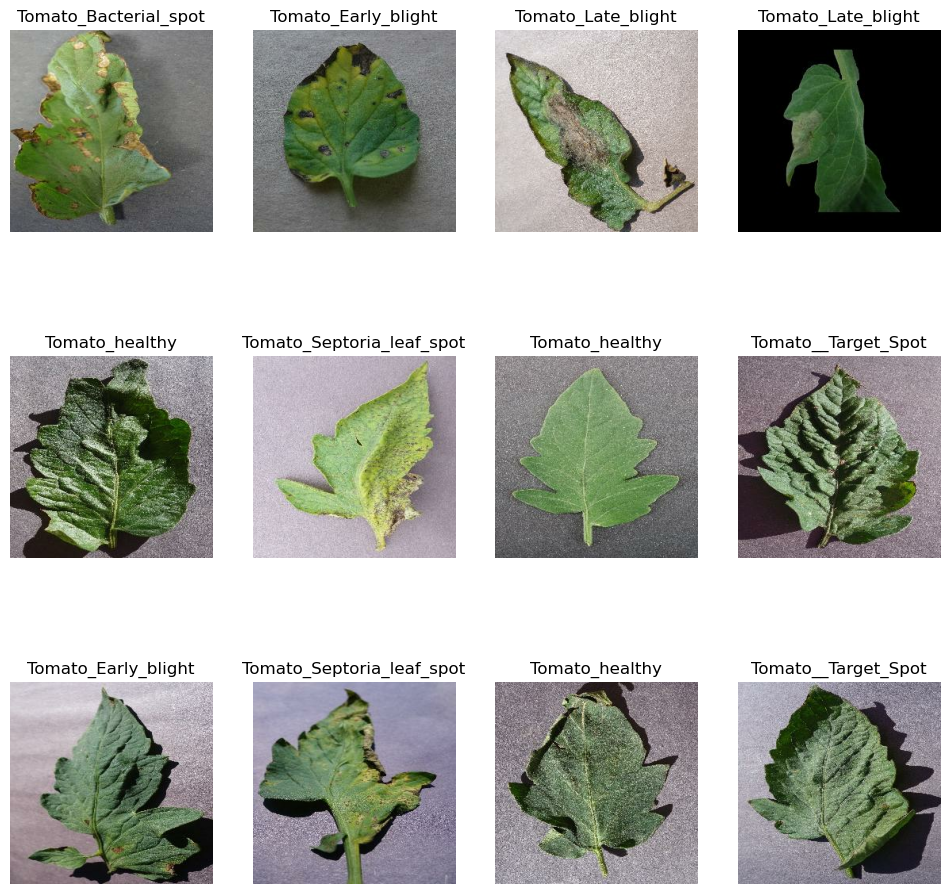

In [8]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):  
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) #plot
        plt.imshow(image_batch[i].numpy().astype("uint8"))  #random
        plt.title(class_names[labels_batch[i]]) 
        plt.axis("off")

# SPLITTING

80% ==>training 20% ==>10% for testing other 10% for validating

In [9]:
len(dataset)    #total images/batch size


88

In [10]:
train_size = 0.8                #580*.8  for training


In [11]:
len(dataset)*train_size


70.4

In [12]:
train_ds = dataset.take(70)     


In [13]:
len(train_ds)

70

In [14]:
test_ds = dataset.skip(70)


In [15]:
len(test_ds)

18

In [16]:
val_size=0.1


In [17]:
len(dataset)*val_size

8.8

In [18]:
val_ds = test_ds.take(8)


In [19]:
len(val_ds)

8

In [20]:
test_ds = test_ds.skip(8)


In [21]:
len(test_ds)

10

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=20000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
len(train_ds)

70

In [25]:
len(val_ds)

8

In [26]:
len(test_ds)

10

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Getting images into same size

In [28]:
resize_and_rescale = tf.keras.Sequential([
    
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
    
])


Changing the image style


In [29]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


BUILDING THE MODEL


In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [31]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10


In [32]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [33]:
model.build(input_shape=input_shape)

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=60,
)

Epoch 1/60
70/70 [==============================] - 198s 2s/step - loss: 2.2381 - accuracy: 0.1813 - val_loss: 2.3047 - val_accuracy: 0.1602
Epoch 2/60
70/70 [==============================] - 178s 3s/step - loss: 1.9653 - accuracy: 0.2790 - val_loss: 2.0600 - val_accuracy: 0.2930
Epoch 3/60
70/70 [==============================] - 155s 2s/step - loss: 1.6617 - accuracy: 0.3982 - val_loss: 2.1589 - val_accuracy: 0.2891
Epoch 4/60
70/70 [==============================] - 153s 2s/step - loss: 1.4742 - accuracy: 0.4741 - val_loss: 1.9410 - val_accuracy: 0.3477
Epoch 5/60
70/70 [==============================] - 151s 2s/step - loss: 1.2797 - accuracy: 0.5308 - val_loss: 2.3323 - val_accuracy: 0.3828
Epoch 6/60
70/70 [==============================] - 150s 2s/step - loss: 1.1560 - accuracy: 0.5830 - val_loss: 1.9668 - val_accuracy: 0.4570
Epoch 7/60
70/70 [==============================] - 156s 2s/step - loss: 1.0417 - accuracy: 0.6232 - val_loss: 1.5326 - val_accuracy: 0.4609
Epoch 8/60
70

Epoch 59/60
70/70 [==============================] - 173s 2s/step - loss: 0.1730 - accuracy: 0.9362 - val_loss: 1.2349 - val_accuracy: 0.7148
Epoch 60/60
70/70 [==============================] - 173s 2s/step - loss: 0.1559 - accuracy: 0.9433 - val_loss: 0.7910 - val_accuracy: 0.7852


In [37]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 9s 648ms/step - loss: 0.7713 - accuracy: 0.8031


In [38]:
scores

[0.7713195085525513, 0.8031250238418579]

In [39]:
history

In [40]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 70}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
type(history.history['loss'])

list

In [43]:
len(history.history['loss'])

60

In [44]:
history.history['loss'][:5] 

[2.2381410598754883,
 1.9653191566467285,
 1.6617006063461304,
 1.4741958379745483,
 1.279719591140747]

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(val_acc)

[0.16015625, 0.29296875, 0.2890625, 0.34765625, 0.3828125, 0.45703125, 0.4609375, 0.5234375, 0.578125, 0.515625, 0.4765625, 0.5625, 0.671875, 0.52734375, 0.5078125, 0.68359375, 0.6875, 0.66796875, 0.59375, 0.67578125, 0.5234375, 0.6875, 0.7265625, 0.58984375, 0.671875, 0.6640625, 0.49609375, 0.6484375, 0.71875, 0.65234375, 0.640625, 0.7265625, 0.72265625, 0.7109375, 0.74609375, 0.74609375, 0.609375, 0.76171875, 0.69921875, 0.59765625, 0.78125, 0.69921875, 0.7578125, 0.625, 0.73046875, 0.71875, 0.64453125, 0.671875, 0.76171875, 0.73828125, 0.79296875, 0.765625, 0.73046875, 0.76953125, 0.75390625, 0.75, 0.73046875, 0.81640625, 0.71484375, 0.78515625]


In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print(val_loss)

[2.3047292232513428, 2.0599732398986816, 2.158946990966797, 1.9410299062728882, 2.332317590713501, 1.9668402671813965, 1.5325806140899658, 1.5881588459014893, 1.3300021886825562, 1.739902138710022, 1.9297951459884644, 1.4774614572525024, 0.9308977723121643, 1.7286967039108276, 1.7779886722564697, 0.9143656492233276, 0.8700224757194519, 0.9962925910949707, 1.4593148231506348, 0.8470089435577393, 2.061318874359131, 0.8750255107879639, 0.6865509748458862, 1.534590721130371, 0.9219628572463989, 1.0073657035827637, 1.7961095571517944, 1.3471051454544067, 0.9835869669914246, 1.1311249732971191, 1.2414206266403198, 0.8076247572898865, 0.903858482837677, 0.9528974890708923, 0.891151487827301, 0.9595785140991211, 1.4957576990127563, 0.7636263370513916, 0.9918863773345947, 1.9384021759033203, 0.6902204155921936, 1.0238100290298462, 0.8912158608436584, 1.7875087261199951, 1.0956542491912842, 1.2043113708496094, 1.5052450895309448, 1.5825508832931519, 0.9747052192687988, 1.2863643169403076, 0.8211

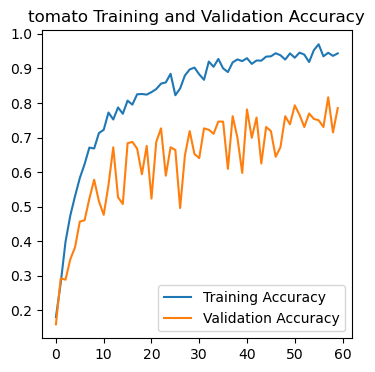

In [47]:
plt.figure(figsize=(4, 4))

plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('tomato Training and Validation Accuracy')


plt.show()

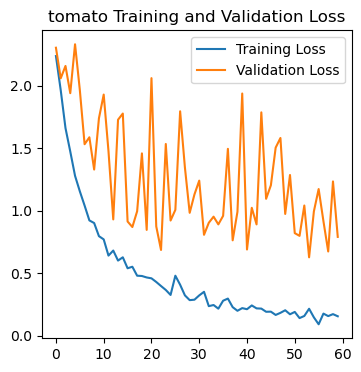

In [48]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('tomato Training and Validation Loss')

plt.show()

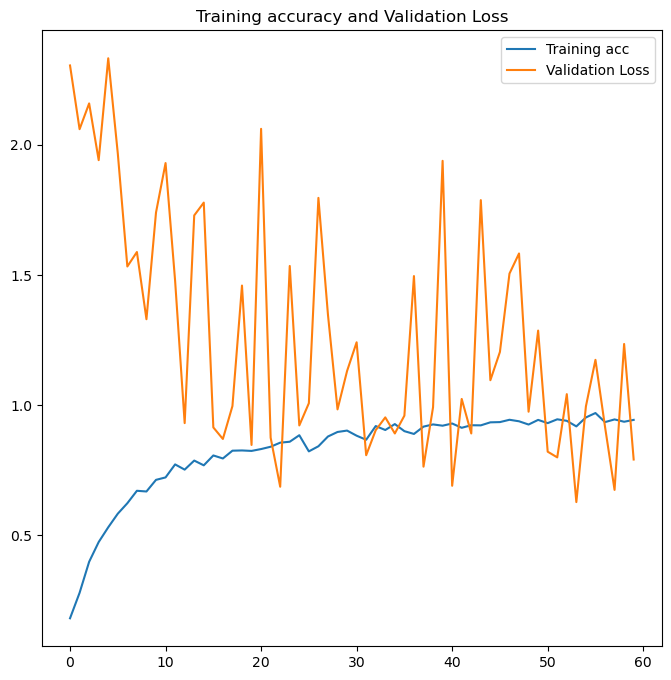

In [49]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), acc, label='Training acc')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training accuracy and Validation Loss')

plt.show()

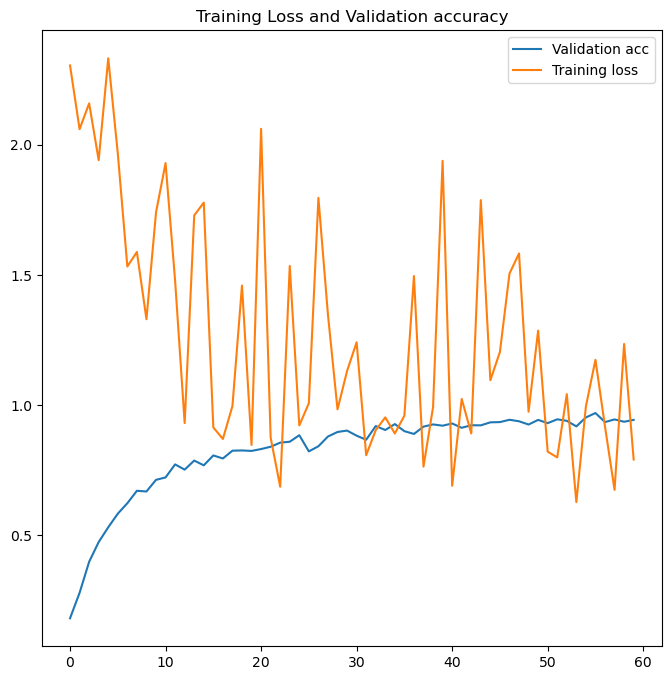

In [50]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), acc, label='Validation acc')
plt.plot(range(EPOCHS), val_loss, label='Training loss')
plt.legend(loc='upper right')
plt.title('Training Loss and Validation accuracy')

plt.show()

first image to predict
actual label: Tomato_Late_blight
1/1 [==============================] - 1s 666ms/step
predicted label: Tomato_Late_blight


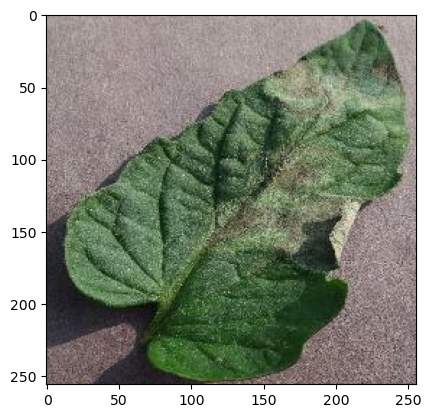

In [59]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 52ms/step


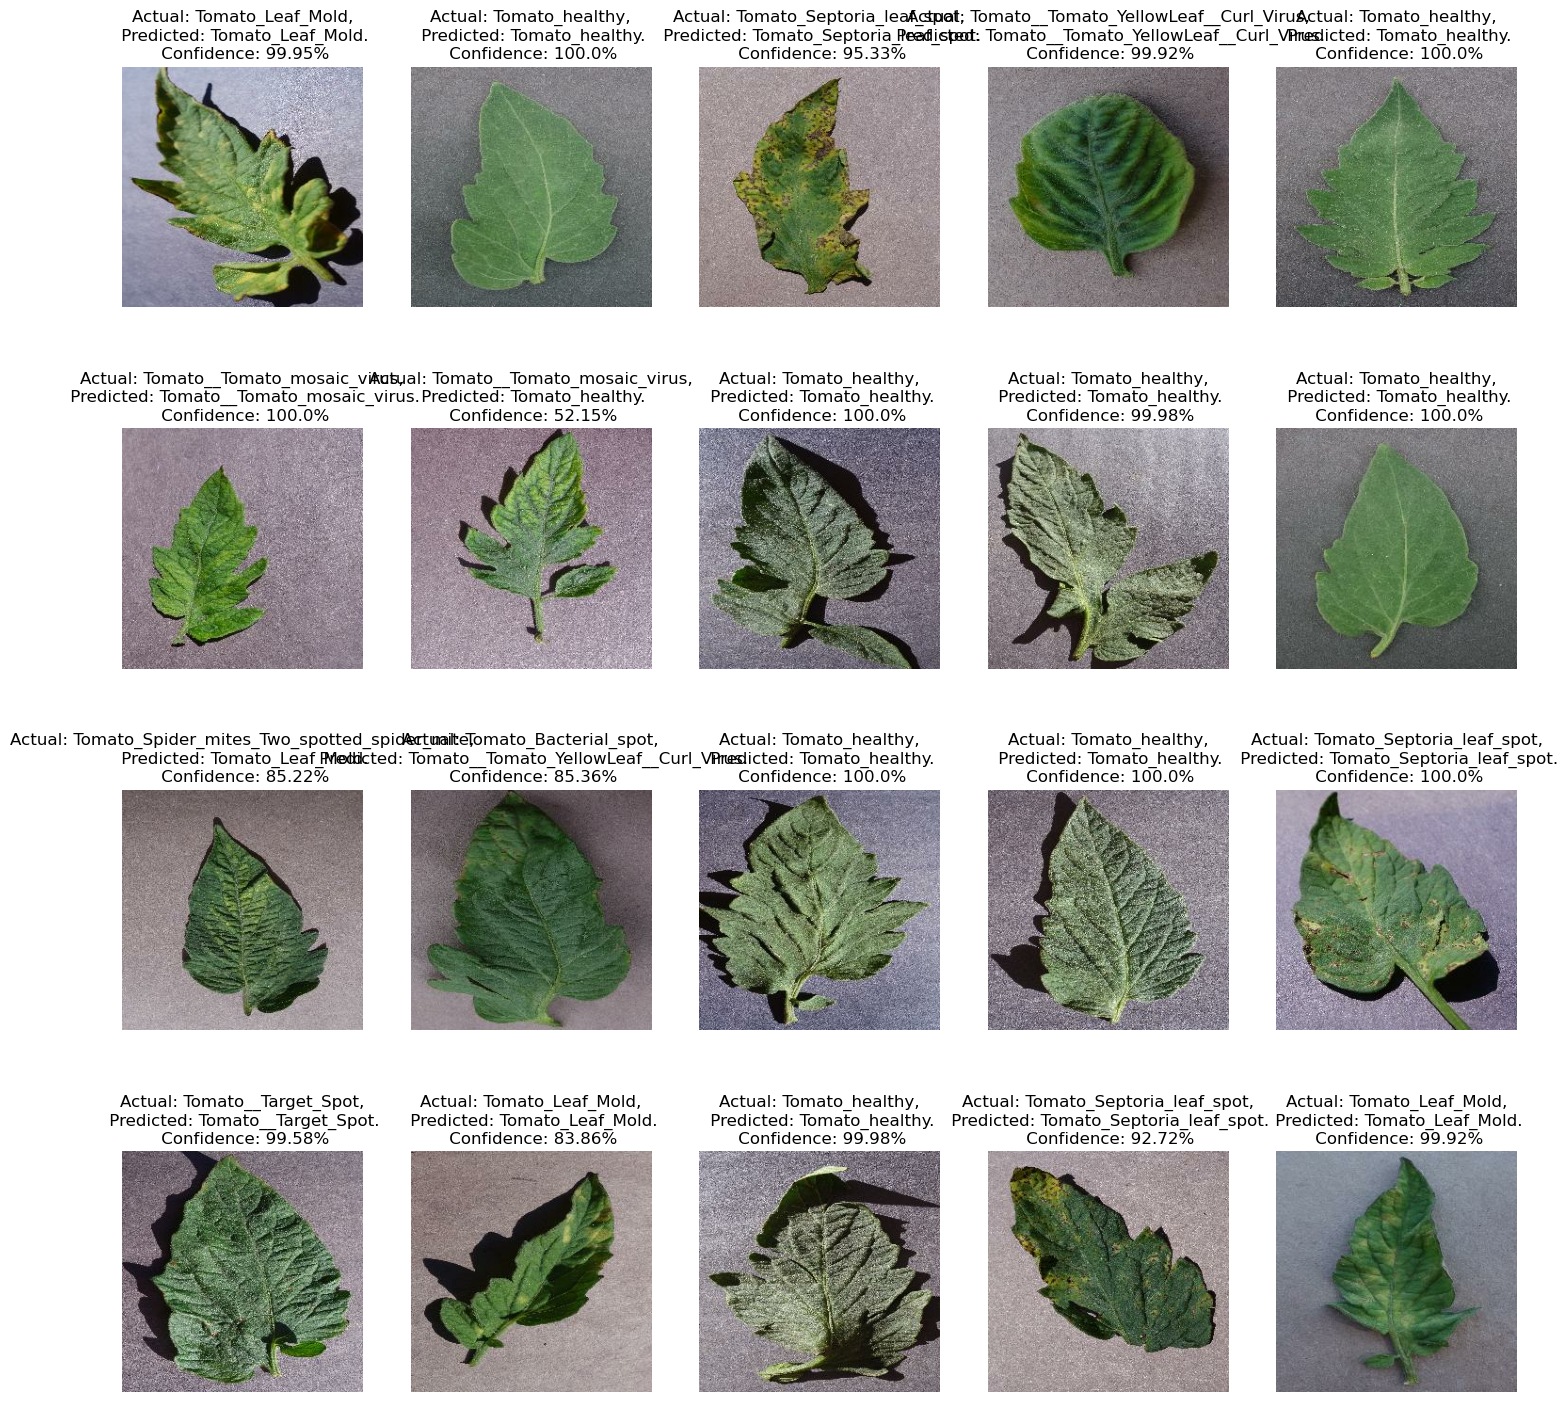

In [60]:
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [54]:
import os
os.listdir("../tomatomodel")

['3', '4']

In [55]:
import os
model_version=max([int(i) for i in os.listdir("../tomatomodel") + [0]])+1
model.save(f"../tomatomodel/{model_version}")

INFO:tensorflow:Assets written to: ../tomatomodel/5\assets


INFO:tensorflow:Assets written to: ../tomatomodel/5\assets


In [56]:
model.save("../tomato.h5")